In [60]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
from typing import Sequence

import matplotlib.pyplot as plt
import torch
from torch import nn

from cc_hardware.utils.file_handlers import PklReader
from cc_hardware.drivers.spads import SPADDataType

from ml.model import DeepLocation8
from ml.pose_cat_dataloader import create_pose_dataloaders

In [115]:
pose_mapping = {}

def load_pose_frames(paths: Path | Sequence[Path], labels: Sequence[str] = None) -> list:
    if isinstance(paths, (str, Path)):
        paths = [Path(paths)]
    if labels is None:
        labels = [p.name for p in paths]
    captures = []
    for p, label in zip(paths, labels):
        p = Path(p)
        assert p.exists(), f"{p} does not exist."
        for pkl in p.glob("**/data.pkl"):
            assert pkl.exists(), f"{pkl} not found."
            reader = PklReader(pkl)
            reader.load(0)
            for frame in reader:
                if "keypoints" in frame:
                    frame[SPADDataType.HISTOGRAM] = frame["histogram"]
                    frame["pose_keypoints"] = frame["keypoints"]
                    if label not in pose_mapping:
                        pose_mapping[label] = len(pose_mapping)
                    frame["pose"] = pose_mapping[label]
                    captures.append(frame)
    print(f"Loaded {len(captures)} captures.")
    return captures

root = Path("../../../logs/2025-06-08/pose")
dirs = [root / name for name in ("arms_out", "arms_side", "arms_up")]
captures = load_pose_frames(dirs)

eval_captures = load_pose_frames([root / name for name in ("arms_side_eval",)], labels=["arms_side"])

pkl_path = dirs[0] / "data.pkl"
pkl_reader = PklReader(pkl_path)
config = pkl_reader.load(0)
assert "config" in config
config = config["config"]

Loaded 300 captures.
Loaded 100 captures.


In [116]:
from torch import optim
import torch.nn as nn
import torch
from tqdm.auto import tqdm

# ---- dataloader ----
cfg_h, cfg_w, cfg_bins = config["height"], config["width"], config["num_bins"]
num_classes = len(set(frame["pose"] for frame in captures))

train_loader, val_loader = create_pose_dataloaders(
    captures, h=cfg_h, w=cfg_w, bins=cfg_bins, window=1, split=0.8
)

eval_loader_eval, _ = create_pose_dataloaders(
    eval_captures, h=cfg_h, w=cfg_w, bins=cfg_bins, window=1, split=1.0
)

# ---- model ----
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DeepLocation8(
    height=cfg_h, width=cfg_w, num_bins=cfg_bins, out_dims=num_classes
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---- training loop ----
epochs = 20
train_losses, val_losses = [], []
for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    t_loss = 0
    for label, hist in train_loader:
        hist, label = hist.to(device), label.to(device)
        optimizer.zero_grad()
        out = model(hist)            # (B, num_classes)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        t_loss += loss.item() * hist.size(0)
    t_loss /= len(train_loader.dataset)

    model.eval()
    v_loss = 0
    with torch.no_grad():
        for label, hist in val_loader:
            hist, label = hist.to(device), label.to(device)
            out = model(hist)
            v_loss += criterion(out, label).item() * hist.size(0)
    v_loss /= len(val_loader.dataset)

    train_losses.append(t_loss)
    val_losses.append(v_loss)

# Save to disk at the same location as the pkl file
model_path = pkl_path.parent / f"{model.__class__.__name__}_epoch{epochs}.pt"
torch.save(model.state_dict(), model_path)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

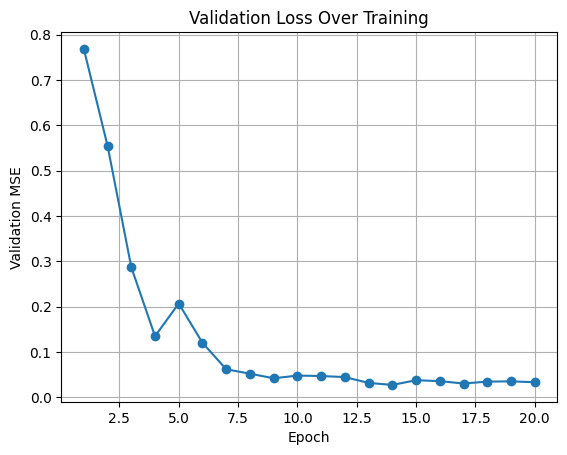

In [117]:
plt.figure()
plt.plot(range(1, len(val_losses) + 1), val_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation MSE")
plt.title("Validation Loss Over Training")
plt.grid(True)
plt.show()

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

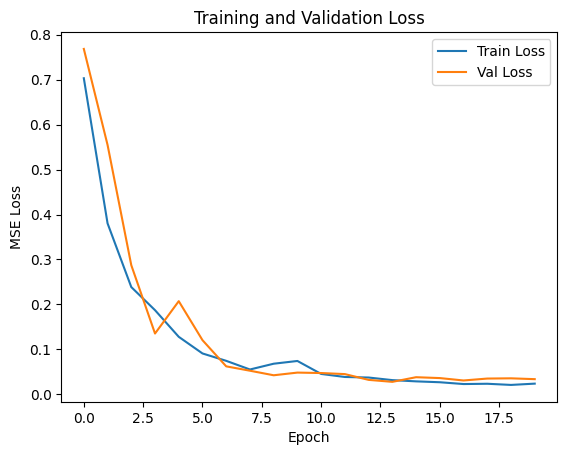

In [118]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ---- compute preds and gts ----
model.eval()
preds, gts = [], []
with torch.no_grad():
    for label, hist in tqdm(val_loader, desc="Evaluating", leave=False):
        hist = hist.to(device)
        out = model(hist)  # (B, num_classes)
        preds.append(out.cpu())
        gts.append(label)
preds = torch.cat(preds)  # shape (N, 34)
gts = torch.cat(gts)      # shape (N, 34)

# ---- plot loss curves ----
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

/var/folders/p4/gpnz03x14t35mnmt__0hjq5h0000gn/T/ipykernel_22129/3676316480.py:32: RuntimeWarning: invalid value encountered in divide
  class_acc = cm.diagonal() / cm.sum(axis=1)


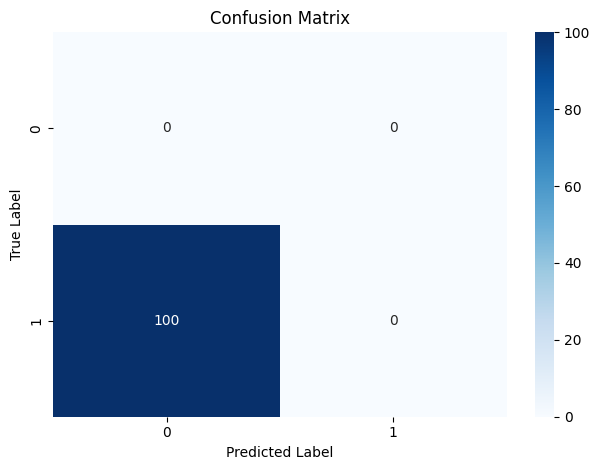

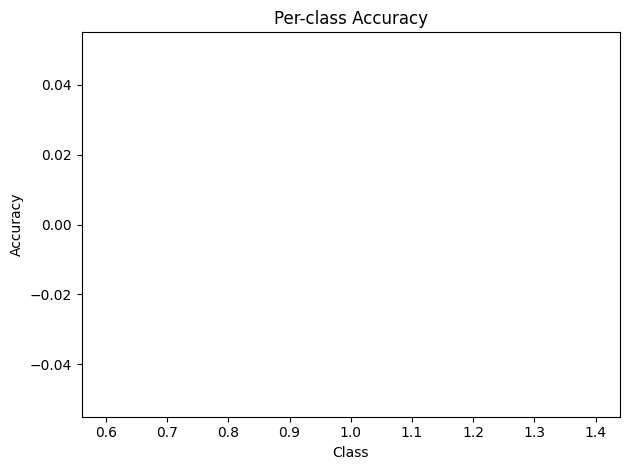

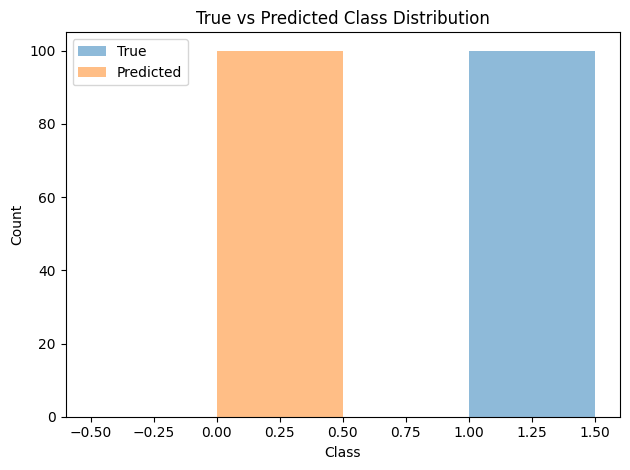

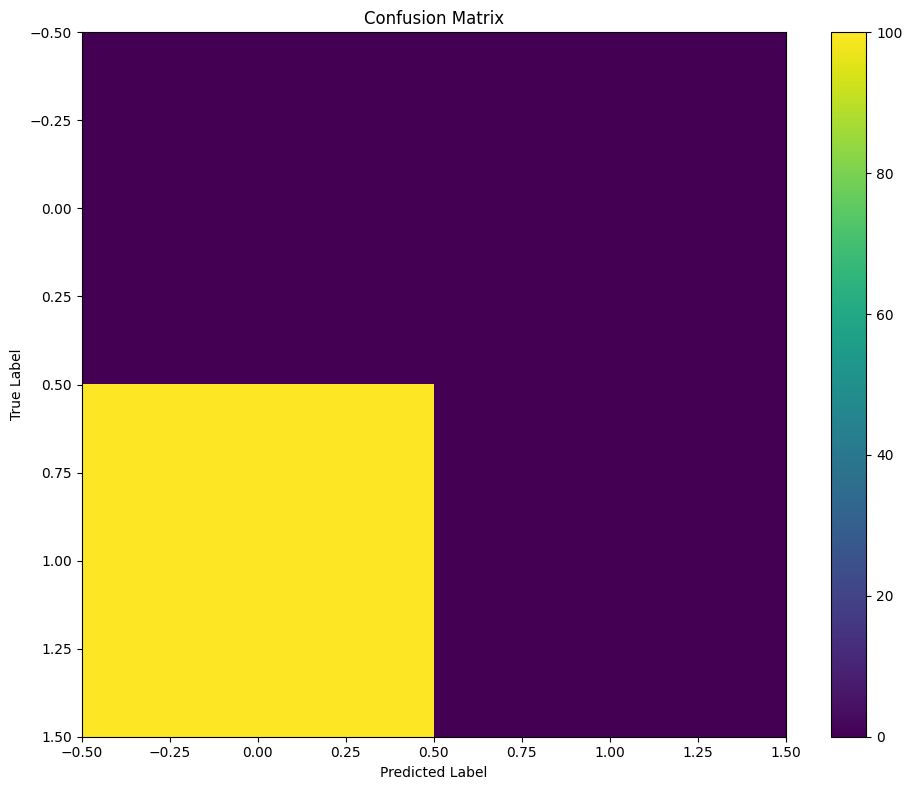

In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns  # optional, for prettier heatmap

# ---- compute preds and gts ----
model.eval()
preds, gts = [], []
with torch.no_grad():
    for label, hist in tqdm(eval_loader_eval, desc="Evaluating", leave=False):
        hist = hist.to(device)
        out = model(hist)  # (B, num_classes)
        preds.append(out.cpu())
        gts.append(label)
preds = torch.cat(preds)  # shape (N, 34)
gts = torch.cat(gts)      # shape (N, 34)

# assume preds (tensor NxC) and gts (tensor N) are defined
pred_labels = preds.argmax(dim=1).cpu().numpy()
true_labels = gts.cpu().numpy()

# confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# per-class accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure()
plt.bar(range(len(class_acc)), class_acc)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-class Accuracy')
plt.tight_layout()

# distribution of predicted vs true
plt.figure()
plt.hist(true_labels, bins=len(class_acc), alpha=0.5, label='True')
plt.hist(pred_labels, bins=len(class_acc), alpha=0.5, label='Predicted')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('True vs Predicted Class Distribution')
plt.legend()
plt.tight_layout()

from sklearn.metrics import confusion_matrix

pred_labels = preds.argmax(dim=1).cpu().numpy()
true_labels = gts.cpu().numpy()

plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_labels, pred_labels)
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()
plt.tight_layout()
plt.show()
